In [224]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [225]:
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Funciones de carga de Datos, Slicing y comparación de errores de modelos

In [226]:
###función para cargar los datos y generar el dataframe ya revuelto usando Pandas
def CargaDatos():
    TrainingData = np.load('proyecto_training_data.npy')
    DataRegression = pd.DataFrame(TrainingData,columns =['SalePrice','OveralQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage'])
    DataRegression = DataRegression.sample(frac = 1, ignore_index=True)
    DataTrain = DataRegression.iloc[0:int(len(DataRegression)*.8),:]
    DataTest = DataRegression.iloc[int(len(DataRegression)*0.8):len(DataRegression), : ]
    

    return DataRegression, DataTrain, DataTest

In [227]:
### Función para los parámetros de la exploración
def ParametrosDatos(b):
    a = b.describe()
    MediasData = a.loc['mean']
    MaxData = a.loc['max']
    MinData = a.loc['min']
    StdData = a.loc['std']
    RangeData = a.loc['max'] - a.loc['min']
    return MediasData, MaxData, MinData, StdData, RangeData

In [228]:
### Función para predicciones con modelos con errores
def PredicModelos(coef1,inter1,coef2,inter2,Xpruebas,Ypruebas):
    Ypruebas = Ypruebas.to_numpy().reshape(-1,1)
    Xpruebas = Xpruebas.to_numpy().reshape(-1,1)
    CoefMano = coef1
    InterMano = inter1
    CoefScikit = coef2
    InterScikit = inter2
    CoefProm = (CoefMano + CoefScikit)/2
    InterProm = (InterMano + InterScikit)/2
    YPredictMano = Xpruebas*CoefMano + InterMano
    YPredictProm = Xpruebas*CoefProm + InterProm
    YScikit = Xpruebas*CoefScikit + InterScikit
    ErrorManual = Ypruebas - YPredictMano
    ErrorProm = Ypruebas - YPredictProm
    ErrorScikit = Ypruebas - YScikit
    dfPredict = pd.DataFrame(np.column_stack([Ypruebas,YPredictMano,YPredictProm,YScikit]),columns = ['YReal','YPredictManual','YPredictProm','YPredictScikit'])
    dfErrores = pd.DataFrame(np.column_stack([ErrorManual,ErrorProm,ErrorScikit]),columns=['ErrorManual','ErrorPromedio','ErrorScikit'])
    return dfPredict, dfErrores


In [229]:
## Main del programa
DatosProyecto, DatosEntreno, DatosPruebas = CargaDatos() #carga los datos completos, el 80% para entrenamiento y el 20% para pruebas
# Se generan 3 Data Frame, uno con los datos totales, otro con los de entreno y otro con los de pruebas.
MediaDatos, MaxDatos, MinDatos, StdDatos, RangoDatos = ParametrosDatos(DatosEntreno)


## Exploración de datos

### Obtención de parámetros generales del bloque completo de datos

In [230]:
print (f'Media de los datos:\n{MediaDatos}')

Media de los datos:
SalePrice       181302.875000
OveralQual           6.120719
1stFlrSF          1170.809075
TotRmsAbvGrd         6.528253
YearBuilt         1971.089041
LotFrontage         70.082463
Name: mean, dtype: float64


In [231]:

print (f'Desviación de los datos:\n{StdDatos}')

Desviación de los datos:
SalePrice       80335.378995
OveralQual          1.386054
1stFlrSF          392.790584
TotRmsAbvGrd        1.654126
YearBuilt          30.030586
LotFrontage        24.936963
Name: std, dtype: float64


In [232]:
print (f'Valores máximos de los datos:\n{MaxDatos}')

Valores máximos de los datos:
SalePrice       755000.0
OveralQual          10.0
1stFlrSF          4692.0
TotRmsAbvGrd        14.0
YearBuilt         2010.0
LotFrontage        313.0
Name: max, dtype: float64


In [233]:
print (f'Valores mínimos de los datos:\n{MinDatos}')

Valores mínimos de los datos:
SalePrice       37900.0
OveralQual          1.0
1stFlrSF          334.0
TotRmsAbvGrd        2.0
YearBuilt        1872.0
LotFrontage        21.0
Name: min, dtype: float64


### Histograma de las variables en el set de entrenamiento

<Figure size 640x480 with 0 Axes>

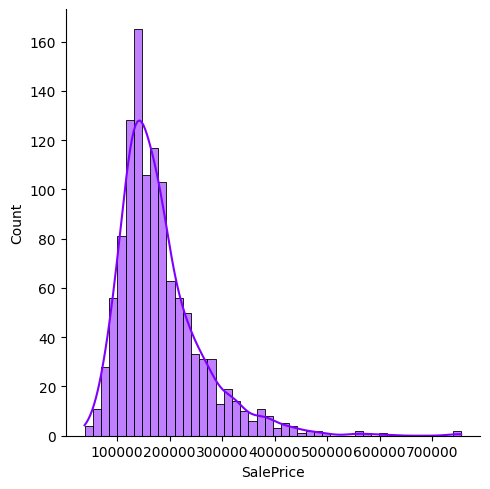

<Figure size 640x480 with 0 Axes>

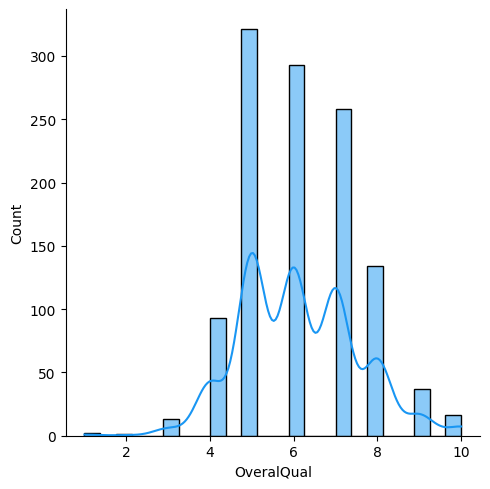

<Figure size 640x480 with 0 Axes>

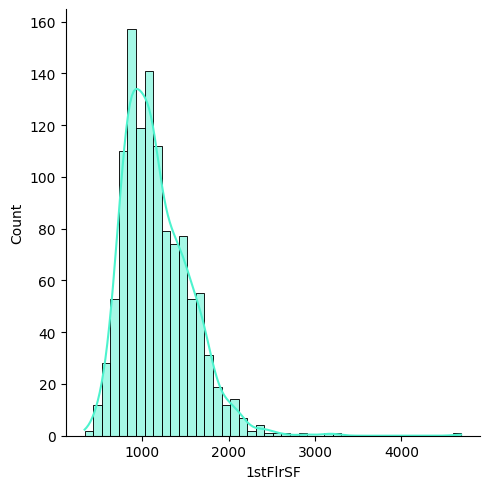

<Figure size 640x480 with 0 Axes>

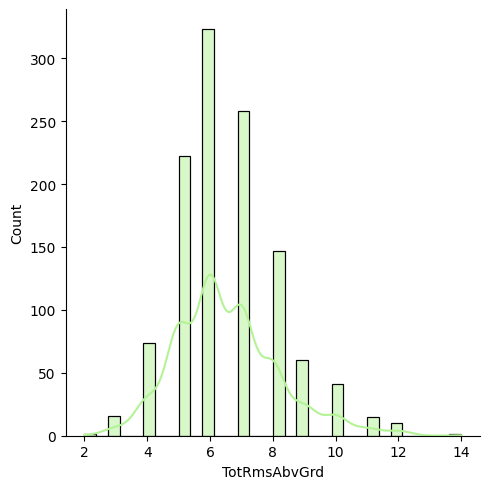

<Figure size 640x480 with 0 Axes>

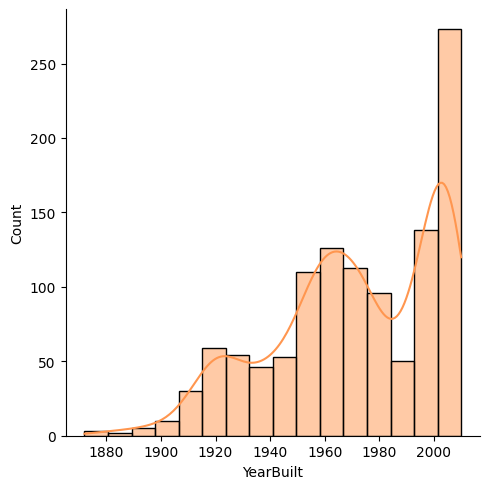

<Figure size 640x480 with 0 Axes>

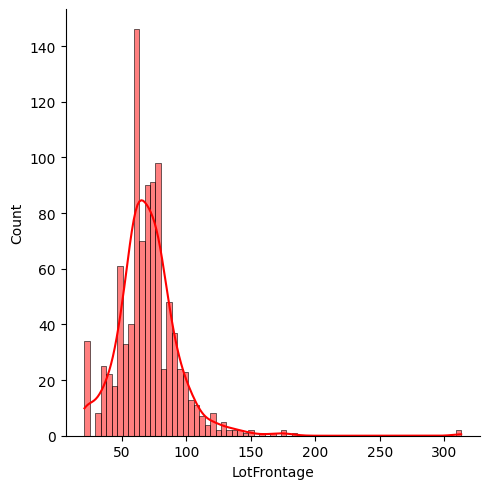

In [234]:
ColorHist = cm.rainbow(np.linspace(0,1,(DatosEntreno.shape[1])))

Ban = 0
for column in DatosEntreno:
    plt.figure()
    sb.displot(DatosEntreno[column], kde = True, color = ColorHist[Ban])
    Ban = Ban + 1

### Calcular el coeficiente de correlación de cada variable del set de entrenamiento


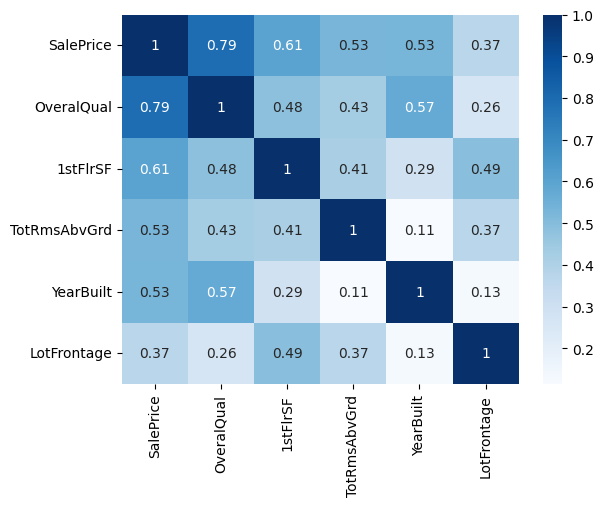

In [235]:
plt.figure()
correlacones = DatosEntreno.corr()
GrafiCorr = sb.heatmap(correlacones, annot = True, cmap = 'Blues',fmt = '0.2g')

### Scatterplot con Correlación como título para el set de entrenamiento

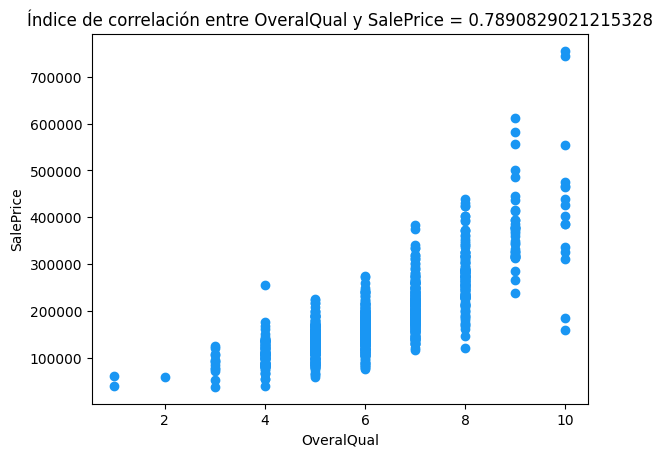

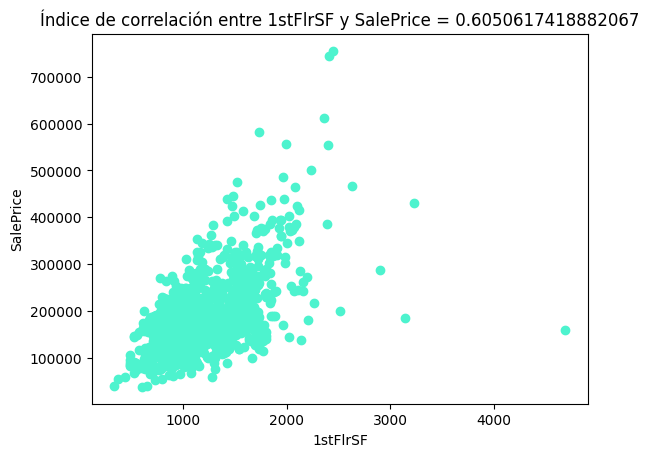

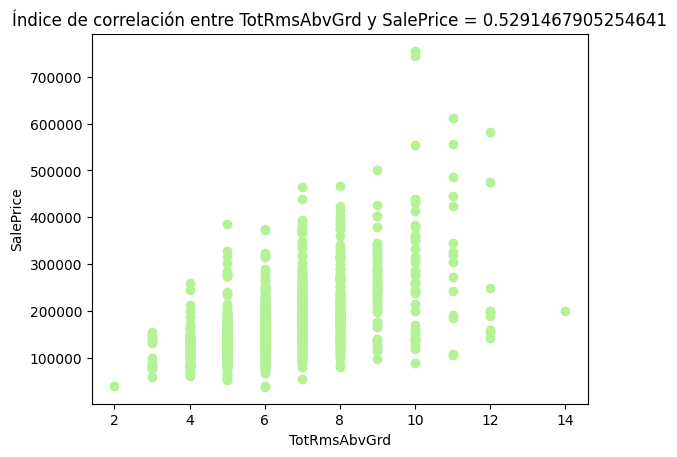

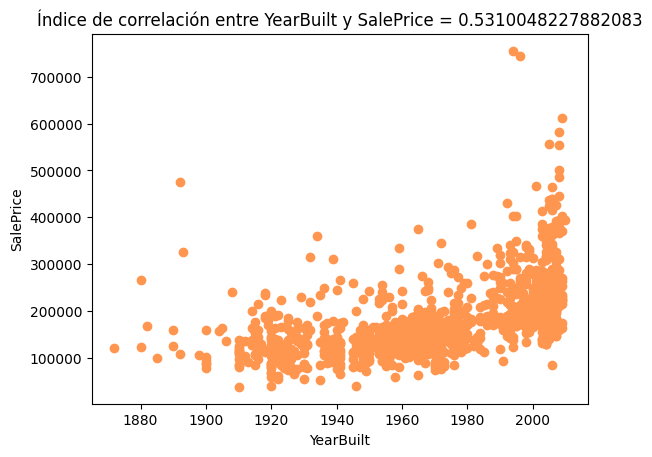

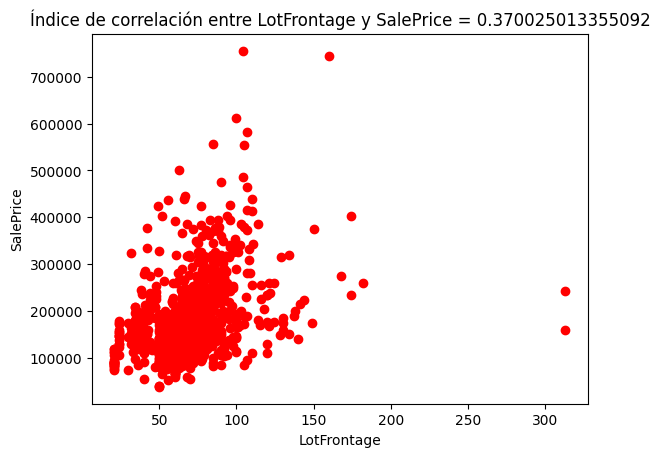

In [236]:
CorrPrecio = DatosEntreno.corr()['SalePrice']
colores = cm.rainbow(np.linspace(0,1,len(CorrPrecio)))
Bandera = 0
for value in DatosEntreno:
    if value != 'SalePrice':
        plt.figure()
        plt.title(f'Índice de correlación entre {value} y SalePrice = {CorrPrecio[Bandera]}')
        plt.xlabel(value)
        plt.ylabel('SalePrice')
        plt.scatter(DatosEntreno[value],DatosEntreno['SalePrice'], color = colores[Bandera])
    Bandera = Bandera + 1
        

## Clase para modelo

In [237]:
class RegLin():
    ### generador de objeto
    def __init__(self, epochs, LearnRate, xData, yData, print_itr):
        self.epochs = epochs
        self.LearningRate = LearnRate
        self.x = xData
        self.y = yData
        self.FinalY = []
        self.print_iters = print_itr
        self.beta0 = 0
        self.beta1 = 0
        self.HistoricBetas = []
        self.HistoricError = []
        self.iter = []
    ### Método para regresion   
    def MetodoReg(self):
        self.beta1 = 0.001
        self.beta0 = 0.001
        yOriginal = self.y.to_numpy().reshape(-1,1)
        self.FinalY = []
        self.HistoricBetas = []
        self.HistoricError = []
        self.iter = []
        x = self.x.to_numpy().reshape(-1,1)
        ones = np.ones_like(x)
        ones = ones.reshape(-1,1)
        Vec = np.hstack([x,ones])
        betas = np.array([self.beta1,self.beta0]).reshape(-1,1)
        self.HistoricBetas.append([self.beta1,self.beta0])
        for index in range (self.epochs):
            result = np.dot(Vec,betas)
            error = 0.5*np.mean(np.power((result-yOriginal),2))
            DelBeta1 = np.mean((result - yOriginal)*x)
            DelBeta0 = np.mean(result - yOriginal)
            self.beta1 = self.beta1 - self.LearningRate*DelBeta1
            self.beta0 = self.beta0 - self.LearningRate*DelBeta0
            betas = np.array([self.beta1,self.beta0]).reshape(-1,1)
            self.HistoricError.append(error)
            self.iter.append(index)
            self.HistoricBetas.append(np.array([self.beta1,self.beta0]))
        self.YFinal = self.beta1*x + self.beta0
    #### Método para graficar el error total
    def PlotError(self):
        plt.figure()
        plt.title('Gráfica error modelo')
        plt.xlabel('Iteraciones')
        plt.ylabel('Error')
        plt.plot(self.iter,self.HistoricError, color = 'green')
    #### Método para graficar el modelo vs scatterplot
    def PlotModelo(self):
        GraphModelo = plt.figure()
        plt.title(f'Modelo de regresión y = {round(self.beta1,3)}x + {round(self.beta0,3)}')
        plt.xlabel(f'Variable independiente {self.x.name}')
        plt.ylabel(f'Variable dependiente {self.y.name}')
        plt.scatter(self.x.to_numpy().reshape(-1,1),self.y.to_numpy().reshape(-1,1))
        plt.plot(self.x.to_numpy().reshape(-1,1),self.YFinal, color = 'red')
    ### Método para graficar evolución de función
    def PlotEvo(self):
        ValueBan = 1
        while(ValueBan <= int(self.epochs/self.print_iters)):
            print(ValueBan*self.print_iters-1)
            
            ytemp = self.x.to_numpy().reshape(-1,1)*self.HistoricBetas[(ValueBan*self.print_iters-1)][0] + self.HistoricBetas[(ValueBan*self.print_iters-1)][1]
            plt.figure()
            plt.title(f'Iteración No.{ValueBan*self.print_iters}')
            plt.xlabel(f'Variable independiente {self.x.name}')
            plt.ylabel(f'Variable dependiente {self.y.name}')
            plt.scatter(self.x.to_numpy().reshape(-1,1),self.y.to_numpy().reshape(-1,1))
            plt.plot(self.x.to_numpy().reshape(-1,1),ytemp, color = 'red')
            ValueBan = ValueBan +1
            

## Pruebas con dos variables independientes

#### Declaración de objetos

In [238]:
Modelo1stFlr = RegLin(7000,0.000001,DatosEntreno['1stFlrSF'],DatosEntreno['SalePrice'],3000)
ModeloOveralqual = RegLin(5000,0.01,DatosEntreno['OveralQual'],DatosEntreno['SalePrice'],3000)

#### Predicciónd de parámetros de cada uno

In [239]:
Modelo1stFlr.MetodoReg()
ModeloOveralqual.MetodoReg()

#### Gráficas de Modelo variable independiente 1stFlr

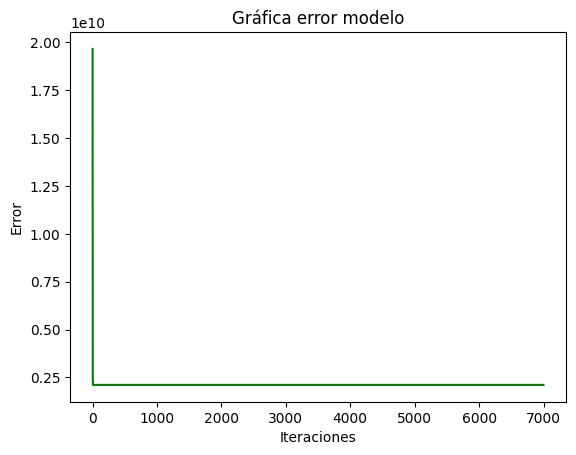

In [240]:
Modelo1stFlr.PlotError()

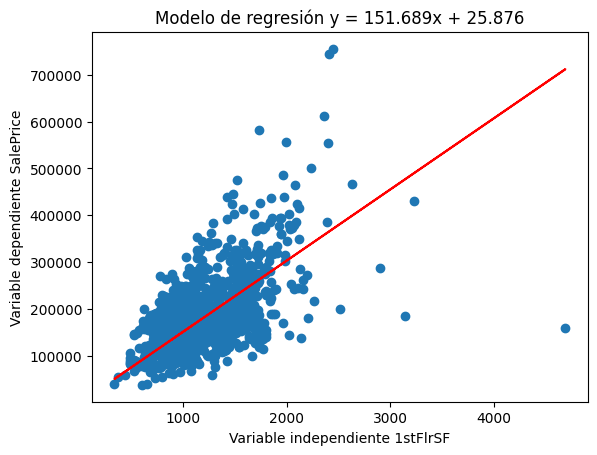

In [241]:
Modelo1stFlr.PlotModelo()

2999
5999


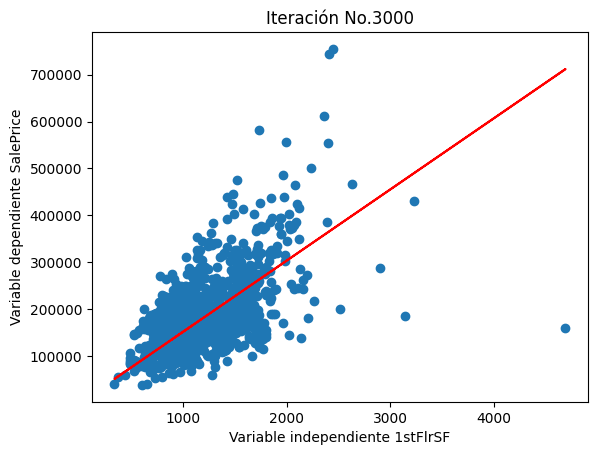

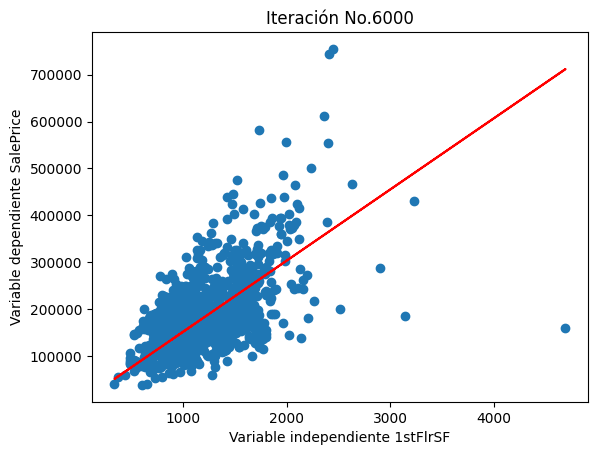

In [242]:
Modelo1stFlr.PlotEvo()

#### Gráficas de modelo con variable dependiente OveralQual

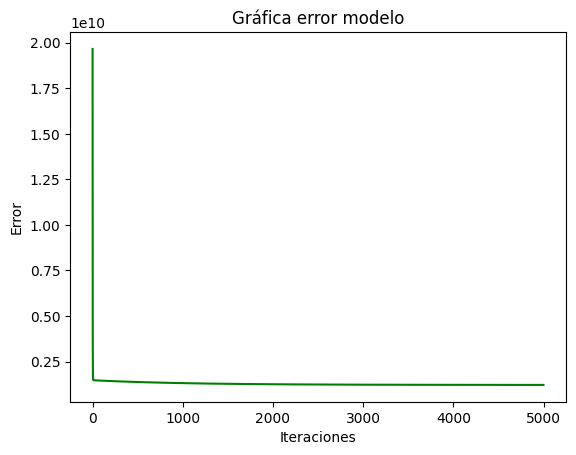

In [243]:
ModeloOveralqual.PlotError()

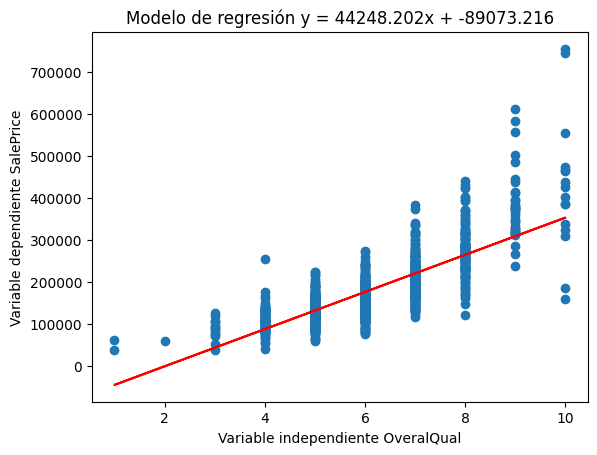

In [244]:
ModeloOveralqual.PlotModelo()

2999


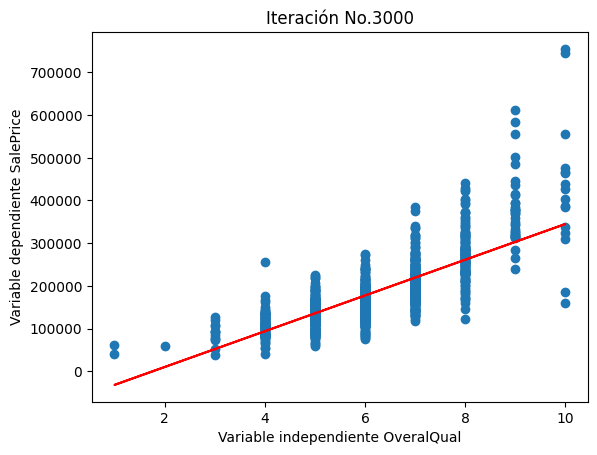

In [245]:
ModeloOveralqual.PlotEvo()


## Pruebas con scikit-learn

In [246]:
### Definiendo variables independientes
x1 = np.array(DatosEntreno['OveralQual']).reshape(-1,1)
x2 = np.array(DatosEntreno['1stFlrSF']).reshape(-1,1)
y = np.array(DatosEntreno['SalePrice']).reshape(-1,1)

In [247]:
Reg1 = LinearRegression()
Reg1.fit(x1,y)
print(Reg1.score(x1,y))

0.6226518264205406


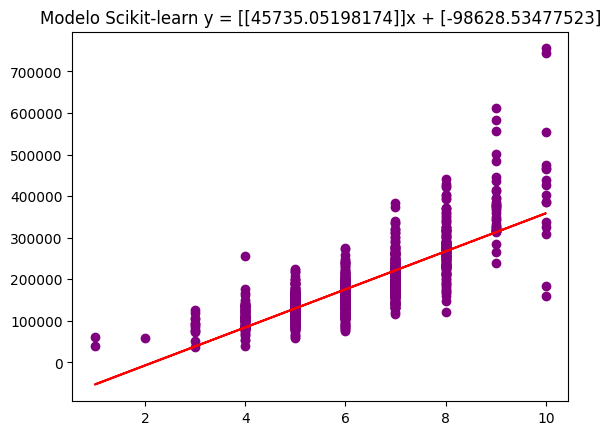

In [248]:
ytest = Reg1.predict(x1)
plt.scatter(x1,y, color = 'purple')
plt.plot(x1,ytest, color = 'red')
plt.title(f'Modelo Scikit-learn y = {Reg1.coef_}x + {Reg1.intercept_}')
plt.show()

In [249]:
Reg2 = LinearRegression()
Reg2.fit(x2,y)
print(Reg2.score(x2,y))

0.3660997114967919


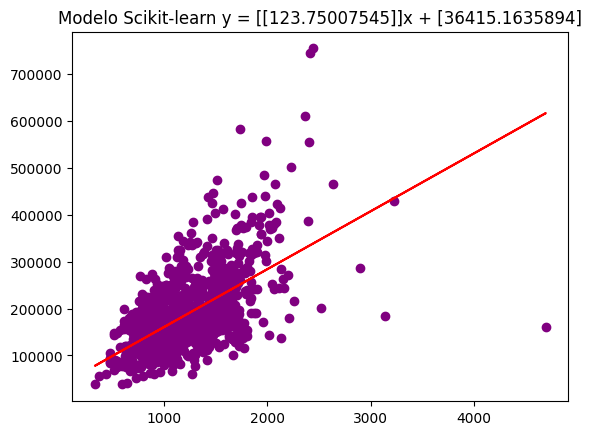

In [250]:
ytest = Reg2.predict(x2)
plt.scatter(x2,y, color = 'purple')
plt.plot(x2,ytest, color = 'red')
plt.title(f'Modelo Scikit-learn y = {Reg2.coef_}x + {Reg2.intercept_}')
plt.show()

### Obteniendo errores

In [251]:
### Datos del modelo OveralQual vs Saleprice
PrediccionesOQual,ErroresOQual = PredicModelos(ModeloOveralqual.beta1,ModeloOveralqual.beta0,Reg1.coef_,Reg1.intercept_,DatosPruebas['OveralQual'],DatosPruebas['SalePrice'])

## Datos del modelo 1stFlrSF vs SAleprice
Pred1stFSF, Errores1stFSF = PredicModelos(Modelo1stFlr.beta1,Modelo1stFlr.beta0,Reg2.coef_,Reg2.intercept_,DatosPruebas['1stFlrSF'],DatosPruebas['SalePrice'])
Pred1stFSF.head()

,YReal,YPredictManual,YPredictProm,YPredictScikit
0,139000.0,146557.166849,151257.451661,155957.736474
1,154900.0,124410.615641,131150.420550,137890.225458
2,254900.0,150349.384521,154700.436441,159051.488360
3,198500.0,75111.785898,86391.618417,97671.450937
4,132500.0,147163.921676,151808.329226,156452.736775
